# Basic drift detection and characterization
This tutorial shows how to implement a basic form of drift characterization on time-stamped data. This data can be from almost any quantum-circuit based experiment on one or more qubits, including suitably time-ordered GST or RB experiments.

In [1]:
# No special imports are required, beyond pygsti
from __future__ import print_function
import pygsti

# Imported for plotting output from the examples, and generate data.
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# To access some simulation functions, we import the drift module. This is not needed to run the analysis on real data
from pygsti import drift

In [2]:
S = 3 #The number of different sequences
Q = 2 #The number of qubits
T = 100 #The number of timestamps
N = 5 #The number of repeats per timestamps

#### Generating fake data
We need some fake data to demonstrate the methods. 

In [3]:
# This box defines some drifting probabilities.
lag_time = 1e-6
sequence_time = 1e-9
tmax = lag_time*T

# Probability ....
def probs0q0(t): return 0.5
def probs0q1(t): return 0.5
def probs1q0(t): return 0.5+0.008*np.cos((t+1/2.)*(T-5)*np.pi/tmax) + 0.05*np.sin(t*0.9*np.pi/tmax) - 0.1*np.cos(t*2.48*np.pi/tmax) 
def probs1q1(t): return 0.5+0.08*np.cos((t+1/2.)*(T-5)*np.pi/tmax)
def probs2q0(t): return 0.5+0.016*np.cos((t+1/2.)*(T-5)*np.pi/tmax) + 0.2*np.sin(t*0.9*np.pi/tmax) - 0.2*np.cos(t*2.48*np.pi/tmax) 
def probs2q1(t): return 0.5+0.3*np.cos((t+1/2.)*(T-5)*np.pi/tmax)

prob = {}
prob[0,0] = probs0q0
prob[0,1] = probs0q1
prob[1,0] = probs1q0
prob[1,1] = probs1q1
prob[2,0] = probs2q0
prob[2,1] = probs2q1

In [4]:
# This box picks some sample times
sample_times = np.zeros((S,T*N),float)
for s in range(0,S):
    for t in range(0,T):
        for n in range(0,N):
            sample_times[s,t*N +n] = sequence_time*(N*s+n) + t*lag_time

In [5]:
# This samples from the drifting probabilities, at the specified sampling times, and course-grains them
data, times, parray = drift.generate_drifting_data(prob,sample_times,coursegrain=N)

### Analysing the data

In [6]:
timestep = 1e-6 # the size of the timestep, in seconds
confidence = 0.95 # the confidence level of the drift detection tests (a value between 0 and 1).

In [7]:
results = pygsti.do_basic_drift_characterization(data, N, timestep=timestep, confidence=confidence)

In [8]:
results.drift_detected # A boolean that reports whether drift was detected

True

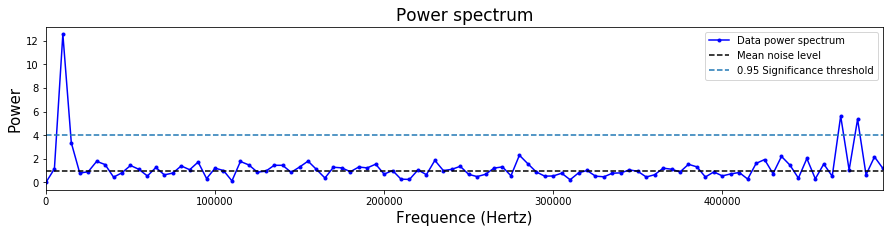

In [9]:
results.plot_power_spectrum()

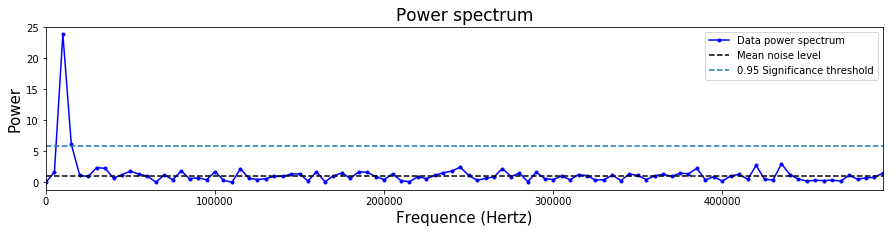

In [10]:
results.plot_power_spectrum(qubit=0)

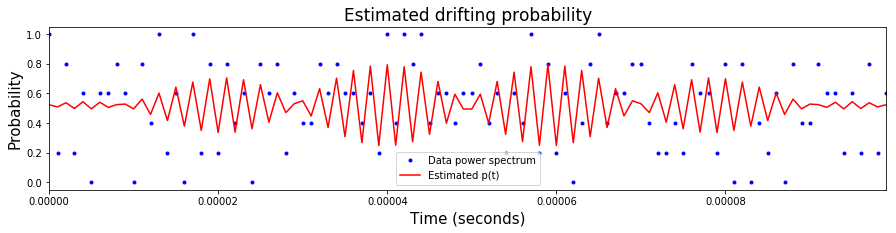

In [11]:
results.plot_estimated_probability(sequence=2,qubit=1)

In [12]:
print("Drift has been detected at the following frequencies, given in Hertz:")
print(results.global_drift_frequencies)

Drift has been detected at the following frequencies, given in Hertz:
[  10000.  470000.  480000.]


In [26]:
results.global_pvalue

3.3195668436292181e-12

In [27]:
results.pq_pvalue

array([  1.88737914e-13,   3.07951454e-05])

In [28]:
results.pspq_pvalue

array([[  6.56576210e-01,   3.92357950e-01],
       [  5.11861922e-04,   2.62978577e-01],
       [  1.17628129e-10,   6.06613319e-06]])

In [29]:
results.pspq_drift_detected

array([[False, False],
       [ True, False],
       [ True,  True]], dtype=bool)

(3.8297682400517052e-11, 1)

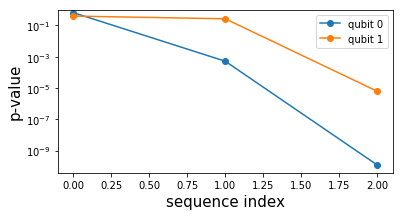

In [33]:
plt.figure(figsize=(6,3))
for q in range(0,Q):
    plt.plot(results.pspq_pvalue[:,q],'o-',label='qubit '+str(q))
plt.yscale("log")
plt.legend()
plt.ylabel("p-value",fontsize=15)
plt.xlabel("sequence index",fontsize=15)
plt.ylim(ymax=1)